In [1]:
from funcs.notebook import *
from funcs.transitmask import get_full_transit_mask, fit_and_remove_transits
from funcs.detrend import custom_detrending, estimate_detrended_noise
import time

import transitleastsquares as tls

sep = "-----------------------------------------"

def mprint(message):
    print(sep)
    print(message)
    print(sep)
    
offset = {"K2":2454833.,"Kepler":2454833.,"TESS":2457000., 
          "Transiting Exoplanet Survey Satellite (TESS)" : 2457000.}    


from altaipony.lcio import from_mast
from altaipony.flarelc import FlareLightCurve

In [2]:
# Composite Table of confirmed exoplanets
path = "20_01_2021_confirmed_uncontroversial_exoplanet_systems.csv"

mprint(f"[UP] Using confirmed and uncontroversial "
      "entries in NASA Composite Table from {path}")

exokepler = pd.read_csv(f"../data/{path}") # composite table

# read in TESS-TOI sample 
path = "../data/2021_01_13_TESS_TOI_CATALOG.csv"

mprint(f"[UP] Using TESS-TOI Table from {path}")

exotess = pd.read_csv(path, skiprows=4)

# rename the relevant columns for transit masking
exotess = exotess.rename(index=str, 
                         columns={'Transit Duration Value':"pl_trandur",
                                  'Orbital Period Value': "pl_orbper",
                                  'Orbital Period Error': "pl_orbpererr",
                                  'Epoch Value':"pl_tranmidepoch",
                                  'Epoch Error':"pl_tranmidepocherr"})


# read in list of LCs to search
es = pd.read_csv("../data/20_01_2021_full_kepler_k2_tess_exoplanet_lcs_some_excluded.csv")

# select only Kepler and TESS, ignore K2 for now
eskeptess = es[(es.mission=="TESS") | (es.mission=="Kepler")]

# read in searched LCs with and without flares
flares = pd.read_csv("../results/2020_02_flares_vetted.csv")
fla = flares[(flares["real?"]==1)]

# pick only LC that were not yet searched
#eskeptess = eskeptess[~eskeptess.ID.isin(fla.ID.unique())]

-----------------------------------------
[UP] Using confirmed and uncontroversial entries in NASA Composite Table from {path}
-----------------------------------------


NumExpr defaulting to 8 threads.


-----------------------------------------
[UP] Using TESS-TOI Table from ../data/2021_01_13_TESS_TOI_CATALOG.csv
-----------------------------------------


In [ ]:
exokepler.columns.values

In [ ]:
flares.groupby(["ID", "qcs"]).count().shape, eskeptess.groupby(["ID", "qcs", "mission"]).count().shape

In [ ]:
ff = fla[["ID", "qcs"]].drop_duplicates(keep="first")

In [ ]:
obsdurs = pd.read_csv("../results/2020_02_obsdurs.csv")
missing = pd.concat([obsdurs, ff]).drop_duplicates(subset=["ID", "qcs"], 
                                                          keep=False)
obsdurs.shape, missing.shape

In [ ]:
a = set(ff.ID.unique())
b = set(obsdurs.ID.unique())
left =  list(a - b)

In [ ]:
len(a), len(b), len(left)

In [ ]:
TSTART = time.time()
n=0
N = ff.shape[0]


for ID in left:
    
    rows = eskeptess[(ID == eskeptess["ID"])]
    
    available_lcs = rows.shape[0]
    for j, row in rows.iterrows():
        # TIC is unique ID for star
        system_tess = exotess[(exotess.TIC == row.TIC)]


        # ID is unique, also ignore entries that have no transits
        # because there is nothing to mask (they are still searched for flares)
        system_kepler = exokepler[(exokepler.hostname == row.ID) &
                           (exokepler.discoverymethod == "Transit")]
        
        system_kepler["pl_orbpererr"] = (system_kepler.pl_orbpererr1 +
                                         system_kepler.pl_orbpererr2) / 2

        try:
            if system_kepler.shape[0] > 0:
                system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                                    offset[system_kepler.iloc[0].disc_facility])
                system_kepler["pl_tranmidepocherr"] = (system_kepler.pl_tranmiderr1 +
                                                  system_kepler.pl_tranmiderr2) / 2
            system = pd.concat([system_kepler, system_tess],ignore_index=True)

        except KeyError:
            system = system_tess
            print(system_kepler.pl_tranmid_systemref)

        # fetch light curve from MAST
        flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short",
                        download_dir="/home/ekaterina/Documents/001_science/lcs")

        # make it a list of LCs even if only one LC is returned
        if type(flc) == FlareLightCurve:

            flc = [flc]

        elif type(flc) == list:

            flc = flc

        # info
        mprint(f"{len(flc)} light curves available for {row.ID} in {row.mission}.")
        
        if row.mission == "TESS":
            flc = flc[:1]

        # loop over all LCs for the system    
        for i, f in enumerate(flc):

            # If any planet transiting
            if system.shape[0] > 0:

                # mask transits
                tranmask = get_full_transit_mask(system, f, pad=0)
                f.flux[tranmask] = np.nan

            # get timestamp for result
            tstamp = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())
            # apply custom detrending
            
            try:
                ts = time.clock()
                fd = custom_detrending(f)
                tf = time.clock()


                # define two hour window for rolling std
                w = np.floor(1. / 12. / np.nanmin(np.diff(fd.time)))
                if w%2==0: 
                    w+=1

                # use window to estimate the noise in the LC
                df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=1.5)

                fin = np.isfinite(df.detrended_flux)

                        # add results to file
                with open("../results/2020_02_obsdurs.csv", "a") as file:
                    s = f"{row.ID},{row.qcs},{i},{df.detrended_flux[fin].shape[0]},{row.mission},{available_lcs}\n"
                    file.write(s)    # info

                with open(f"../results/observedtimes/{row.ID}_{row.qcs}_{i}_{row.mission}.csv", "w") as file:
                    d = pd.DataFrame({"time":df.time[fin],"flux":df.detrended_flux[fin]})
                    d.to_csv(file,index=False)
            except Exception as err:
                with open("../results/nodetrend_phase.txt", "a") as file:
                    s = f"{row.ID},{row.qcs},{row.mission},{tstamp},{i},{err}\n"
                    file.write(s)
        n += 1
        print(f"{n / N * 100.:.1f}%, [{n}/{N}]")

        # breathe
        time.sleep(10)

TSTOP = time.time()
mprint(f"Analysis of {N} light curves took {(TSTOP - TSTART) / 60. / 60.:.1f} hours.")

# Add one

In [3]:
row = eskeptess[("WASP-100" == eskeptess["ID"])].iloc[1]
print(row.qcs)

2


In [4]:
%matplotlib inline
# TIC is unique ID for star
system_tess = exotess[(exotess.TIC == row.TIC)]

# ID is unique, also ignore entries that have no transits
# because there is nothing to mask (they are still searched for flares)
system_kepler = exokepler[(exokepler.hostname == row.ID) &
                   (exokepler.discoverymethod == "Transit")]

try:
    if system_kepler.shape[0] > 0:
        system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                            offset[system_kepler.iloc[0].disc_facility])
    system = pd.concat([system_kepler, system_tess],ignore_index=True)

except KeyError:
    system = system_tess
    print(system.columns)

    
system.T

Index(['Source Pipeline', 'TIC', 'Full TOI ID', 'TOI Disposition',
       'TIC Right Ascension', 'TIC Declination', 'TMag Value',
       'TMag Uncertainty', 'pl_tranmidepoch', 'pl_tranmidepocherr',
       'pl_orbper', 'pl_orbpererr', 'pl_trandur', 'Transit Duration Error',
       'Transit Depth Value', 'Transit Depth Error', 'Sectors',
       'Public Comment', 'Surface Gravity Value',
       'Surface Gravity Uncertainty', 'Signal ID', 'Star Radius Value',
       'Star Radius Error', 'Planet Radius Value', 'Planet Radius Error',
       'Planet Equilibrium Temperature (K) Value',
       'Effective Temperature Value', 'Effective Temperature Uncertainty',
       'Effective Stellar Flux Value', 'Signal-to-noise', 'Centroid Offset',
       'TFOP Master', 'TFOP SG1a', 'TFOP SG1b', 'TFOP SG2', 'TFOP SG3',
       'TFOP SG4', 'TFOP SG5', 'Alerted', 'Updated'],
      dtype='object')


,433
Source Pipeline,qlp
TIC,38846515
Full TOI ID,106.01
TOI Disposition,KP
TIC Right Ascension,68.9597
TIC Declination,-64.027
TMag Value,10.307
TMag Uncertainty,0.019
pl_tranmidepoch,2153.07
pl_tranmidepocherr,0.000144


In [5]:
# fetch light curve from MAST
flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short",
                download_dir="/home/ekaterina/Documents/001_science/lcs")

# make it a list of LCs even if only one LC is returned
if type(flc) == FlareLightCurve:

    flc = [flc]

elif type(flc) == list:

    flc = flc

# info
mprint(f"{len(flc)} light curves available for {row.ID} in {row.mission}.")

if row.mission == "TESS":
    flc = flc[:1]

/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/lightkurve/io/tess.py:34: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/lcs/mastDownload/TESS/tess2018234235059-s0002-0000000038846515-0121-s/tess2018234235059-s0002-0000000038846515-0121-s_lc.fits' mode='rb' closefd=True>
  lc = read_generic_lightcurve(filename, flux_column=flux_column, time_format="btjd")
2% (399/18699) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
2% (399/18699) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


-----------------------------------------
2 light curves available for WASP-100 in TESS.
-----------------------------------------


/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/lightkurve/io/tasoc.py:26: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/lcs/mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00038846515-s02-c0120_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00038846515-s02-c0120_tess_v04_lc.fits' mode='rb' closefd=True>
  filename, flux_column=flux_column.lower(), time_format="btjd"


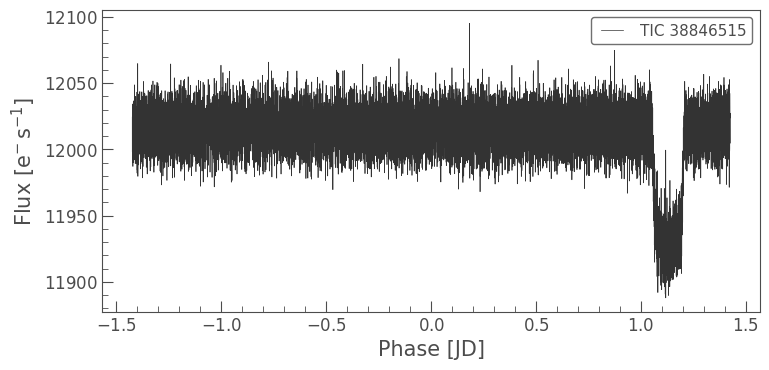

In [6]:
flc[0].fold(system.pl_orbper.iloc[0]).plot();

In [11]:
system.columns.values

array(['Source Pipeline', 'TIC', 'Full TOI ID', 'TOI Disposition',
       'TIC Right Ascension', 'TIC Declination', 'TMag Value',
       'TMag Uncertainty', 'pl_tranmidepoch', 'pl_tranmidepocherr',
       'pl_orbper', 'pl_orbpererr', 'pl_trandur',
       'Transit Duration Error', 'Transit Depth Value',
       'Transit Depth Error', 'Sectors', 'Public Comment',
       'Surface Gravity Value', 'Surface Gravity Uncertainty',
       'Signal ID', 'Star Radius Value', 'Star Radius Error',
       'Planet Radius Value', 'Planet Radius Error',
       'Planet Equilibrium Temperature (K) Value',
       'Effective Temperature Value', 'Effective Temperature Uncertainty',
       'Effective Stellar Flux Value', 'Signal-to-noise',
       'Centroid Offset', 'TFOP Master', 'TFOP SG1a', 'TFOP SG1b',
       'TFOP SG2', 'TFOP SG3', 'TFOP SG4', 'TFOP SG5', 'Alerted',
       'Updated'], dtype=object)

/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.024992571999998603 1.6563118590000023 0.5327134529999995 0.5224617209999991 0.4823649500000009 0.541823793999999 3.7606683489999995
2.84938 1e-06
38846515
No transit duration uncertainty given.
[1354.10896202 1354.11035092 1354.11173982 ... 1381.51188943 1381.51327832
 1381.5146672 ] [0.99995465 1.00119526 0.99734037 ... 1.00016973 0.99824951 1.00051109] (18300,) (18300,)
2.137035 4.27407 9 0.08 1.3 0.13 1.3 9
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 27 durations
Searching 18300 data points, 282 periods from 2.139 to 3.045 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 periods | 00:05<00:00
/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/transitleastsquares/helpers.py:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = idx.astype(numpy.int)  # needed if oversampling_factor is not int
/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keep

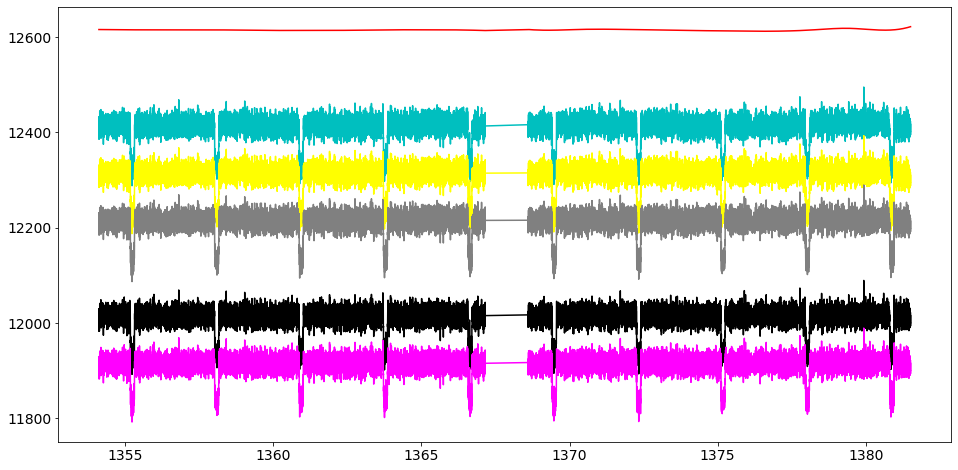

In [9]:
# loop over all LCs for the system    
for i, f in enumerate(flc):


    # get timestamp for result
    tstamp = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())
    # apply custom detrending

    try:
        ts = time.process_time()

        fd = custom_detrending(f, system=system)
        tf = time.process_time()

        # If any planet transiting
        if system.shape[0] > 0:
            for j,r in system.iterrows():

                timearr, flux = tls.cleaned_array(fd.time.value, fd.detrended_flux.value)
              
                notransit_flux, results = fit_and_remove_transits(timearr, flux,
                                                                 pl_orbper=r.pl_orbper)
                fd.detrended_flux = notransit_flux


        # define two hour window for rolling std
        w = np.floor(1. / 12. / np.nanmin(np.diff(fd.time.value)))
        if w%2 == 0: 
            w += 1

        # use window to estimate the noise in the LC
        df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=2.5)

        fin = np.isfinite(df.detrended_flux.value)
    #         print(df.detrended_flux[fin].shape)

                # add results to file
        with open("../results/2020_02_obsdurs.csv", "a") as file:
            s = f"{row.ID},{row.qcs},{i},{df.detrended_flux[fin].shape[0]},{row.mission},2\n"
            file.write(s)    # info

        with open(f"../results/observedtimes/{row.ID}_{row.qcs}_{i}_{row.mission}.csv", "w") as file:
            d = pd.DataFrame({"time":df.time.value[fin],"flux":df.detrended_flux[fin]})
            d.to_csv(file,index=False)
    except Exception as err:
        print(err)
        with open("../results/nodetrend_phase.txt", "a") as file:
            s = f"{row.ID},{row.qcs},{row.mission},{tstamp},{i},{err}\n"
            file.write(s)

(11850.0, 12200.0)

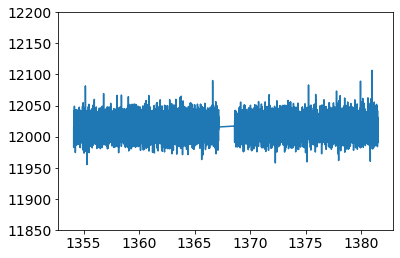

In [10]:

plt.plot(timearr, notransit_flux)
# plt.plot(timearr, flux)
plt.ylim(1.185e4,1.22e4)

In [ ]:
fd.flux.shape

In [ ]:
df.fold(system.pl_orbper.iloc[0]).plot();

In [ ]:
system.pl_orbper, results.period

# Backlog

In [ ]:
#work through a subset first
# row = fla.iloc[158]
phases = []
trandurs = []
for label, row in fla.iterrows():

    # TIC is unique ID for star
    system_tess = exotess[(exotess.TIC == row.ID)]

    # ID is unique, also ignore entries that have no transits
    # because there is nothing to mask (they are still searched for flares)
    system_kepler = exokepler[(exokepler.hostname == row.ID) &
                       (exokepler.discoverymethod == "Transit")]

    try:
        if system_kepler.shape[0] > 0:
            system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                                offset[system_kepler.iloc[0].disc_facility])

        system = pd.concat([system_kepler, system_tess],ignore_index=True)
        system = system.sort_values(by="pl_orbper",ascending=True).iloc[0]

        tmid = system.pl_tranmidepoch
        orbper = system.pl_orbper
        tflare = row.tstart
        phase = ((tflare - tmid) % orbper) / orbper
        trandurs.append(system.pl_trandur / 24. / orbper)
        phases.append(phase)
        print(phase)
    except KeyError:
        phases.append(np.nan)
        trandurs.append(0.)
        print("nope")
    except IndexError:
        phases.append(np.nan)
        trandurs.append(0.)
        print("nope")

In [ ]:
st = startrandurs[~np.isnan(startrandurs)]
np.percentile(np.sort(st),90)

In [ ]:
plt.figure(figsize=(8,5))

hist = plt.hist(phases, bins=np.linspace(0,1,10), histtype="step",edgecolor="r")
plt.axvline(np.nanmean(startrandurs), c="k", label="mean transit duration")
plt.axvline(np.percentile(np.sort(st),95), c="grey", label="95th percentile transit duration")
plt.axvline(np.nanmax(startrandurs), c="silver", label="")
plt.axhline(np.mean(hist[0]),c="orange",label="mean")
plt.fill_between(hist[1],np.mean(hist[0]) - np.std(hist[0]),
                 np.mean(hist[0]) + np.std(hist[0]),alpha=.4,
                 label="standard deviation")
# plt.axhline(np.mean(hist[0]) - np.std(hist[0]))
plt.xlim(0,1)
plt.legend(frameon=False);

In [ ]:
np.std(hist[0])

In [ ]:
fla["phase"] = phases
fla["frac_tran"] = trandurs

In [ ]:
startrandurs = fla.drop_duplicates(subset=["ID"]).frac_tran

In [ ]:
plt.hist(startrandurs, bins=np.logspace(-3,-.5,15), histtype="step", edgecolor="k")
plt.xscale("log")
plt.xlabel("duration of transit / orbital period")
plt.title(f"{len(startrandurs)} star-planet-systems with flares")

In [ ]:
np.sum(startrandurs)/len(startrandurs)

- tranmidepoch is phase 0

- select innermost component in multiplanet systems
- calculate pseudotransit mid epoch for RV planets


- the correct metric is number of flares per observed phase

In [ ]:
0.009200275324758905 * 3000

In [ ]:
system.columns

In [2]:
import pandas as pd